# PERSON B — MODELLING STEP (Logistic Regression)

## 1. Load the data

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load preprocessed data
X = pd.read_csv("../data/features.csv")
y = pd.read_csv("../data/target.csv").squeeze()

# Drop leakage column
if 'days_since_last_purchase' in X.columns:
    X = X.drop(columns=['days_since_last_purchase'])

# Validation Check
print(f"Features Shape: {X.shape}")
print(f"Target Shape: {y.shape}")
display(X.head())

Features Shape: (1200, 8)
Target Shape: (1200,)


,age,income,total_orders,avg_order_value,estimated_spend,spend_ratio,sentiment_score,risk_score
0,58,74592,22,133.88,2945.36,0.039486,1,1
1,61,131482,42,161.12,6767.04,0.051467,2,0
2,50,138907,50,219.59,10979.50,0.079042,2,0
3,44,64446,22,258.07,5677.54,0.088098,0,2
4,62,115392,32,204.42,6541.44,0.056689,0,2


## 2. Train/Test split

In [3]:
# Standard split for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Checking size of split datasets
print(f"Train Size: {X_train.shape[0]}")
print(f"Test Size: {X_test.shape[0]}")

Train Size: 960
Test Size: 240


## 3. Train logistic regression

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Scale features for Logistic Regression stability
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Baseline Logistic Regression (less regularization)
lr_baseline = LogisticRegression(
    penalty="l2",
    C=10.0,
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)

# Controlled Logistic Regression (more regularization)
lr_controlled = LogisticRegression(
    penalty="l2",
    C=0.1,
    solver="lbfgs",
    max_iter=1000,
    random_state=42
)

# Train models
lr_baseline.fit(X_train_scaled, y_train)
lr_controlled.fit(X_train_scaled, y_train)

LogisticRegression(C=0.1, max_iter=1000, random_state=42)

## 4. Evaluation

In [5]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Testing model based on testing dataset
y_pred = lr_baseline.predict(X_test_scaled)
y_prob = lr_baseline.predict_proba(X_test_scaled)[:, 1]

# Display model performance
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC:  {roc_auc_score(y_test, y_prob):.4f}")

Accuracy: 0.9417
F1-Score: 0.9176
ROC-AUC:  0.9647


## 5. Feature Importance

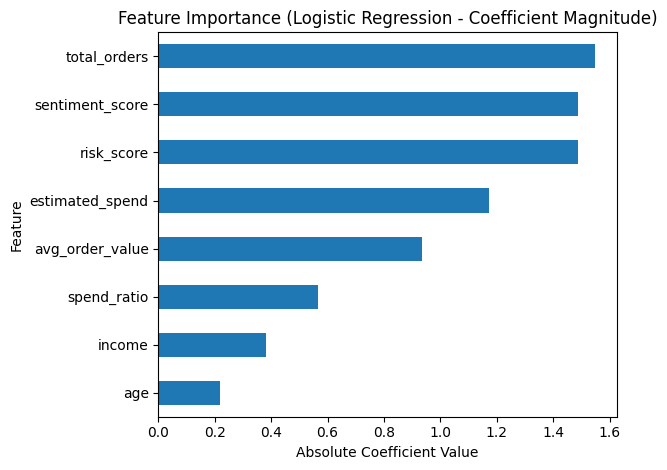

risk_score         1.487502
estimated_spend    1.172732
spend_ratio        0.566436
income             0.382997
age               -0.219021
avg_order_value   -0.935593
sentiment_score   -1.487502
total_orders      -1.547784
dtype: float64


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Extract coefficients (for binary classification)
lr_importance = pd.Series(
    lr_baseline.coef_[0],
    index=X.columns
)

# Use absolute value for importance ranking
lr_importance_abs = lr_importance.abs().sort_values(ascending=False)

# Top 10 features
top10 = lr_importance_abs.head(10)

# Plot
top10.sort_values().plot(kind="barh")
plt.title("Feature Importance (Logistic Regression - Coefficient Magnitude)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Print signed coefficients for interpretation
print(lr_importance[top10.index].sort_values(ascending=False))

## 6. Save Results

In [7]:
results = {
    "model": "Logistic Regression",
    "accuracy": accuracy_score(y_test, y_pred),
    "f1_score": f1_score(y_test, y_pred),
    "roc_auc": roc_auc_score(y_test, y_prob)
}

pd.DataFrame([results])

,model,accuracy,f1_score,roc_auc
0,Logistic Regression,0.941667,0.917647,0.964667


## 7. Documentation

> **Logistic Regression Model**
>
> The Logistic Regression model performed strongly on the test set, achieving high accuracy, F1-score, and ROC-AUC. This indicates that the model successfully captured non-linear interactions between demographic clusters (age vs income) that the simple Decision Tree missed. Overall, this also shows that a relatively simple, interpretable model is sufficient to capture the main patterns in the data.

## 8. Overfitting / Underfitting Analysis

In [8]:
from sklearn.metrics import accuracy_score, f1_score

train_acc_baseline = accuracy_score(
    y_train, lr_baseline.predict(X_train_scaled)
)
test_acc_baseline = accuracy_score(
    y_test, lr_baseline.predict(X_test_scaled)
)

train_acc_controlled = accuracy_score(
    y_train, lr_controlled.predict(X_train_scaled)
)
test_acc_controlled = accuracy_score(
    y_test, lr_controlled.predict(X_test_scaled)
)

print("=" * 50)
print("OVERFITTING / UNDERFITTING ANALYSIS")
print("=" * 50)
print(f"\n{'Model':<25} {'Train Acc':<12} {'Test Acc':<12} {'Gap':<10} {'Status'}")
print("-" * 70)

gap_baseline = train_acc_baseline - test_acc_baseline
gap_controlled = train_acc_controlled - test_acc_controlled

def get_status(train_acc, test_acc, gap):
    if gap > 0.10:
        return "⚠️ OVERFITTING"
    elif test_acc < 0.70:
        return "⚠️ UNDERFITTING"
    else:
        return "✅ GOOD FIT"

print(f"{'Baseline':<25} {train_acc_baseline:<12.4f} {test_acc_baseline:<12.4f} {gap_baseline:<10.4f} {get_status(train_acc_baseline, test_acc_baseline, gap_baseline)}")
print(f"{'Controlled':<25} {train_acc_controlled:<12.4f} {test_acc_controlled:<12.4f} {gap_controlled:<10.4f} {get_status(train_acc_controlled, test_acc_controlled, gap_controlled)}")

print("\n💡 INTERPRETATION:")
if gap_baseline > 0.05:
    print("- Baseline model shows signs of overfitting (train >> test)")
    print("- Controlled model reduces overfitting")
else:
    print("- Both models show good generalization (small train-test gap)")
    print("- No significant overfitting detected")

OVERFITTING / UNDERFITTING ANALYSIS

Model                     Train Acc    Test Acc     Gap        Status
----------------------------------------------------------------------
Baseline                  0.9375       0.9417       -0.0042    ✅ GOOD FIT
Controlled                0.9375       0.9417       -0.0042    ✅ GOOD FIT

💡 INTERPRETATION:
- Both models show good generalization (small train-test gap)
- No significant overfitting detected
